In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
from glob import glob
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision

seed = 42

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Currently using "{device}" device.')

Currently using "cuda" device.


In [ ]:
import os
os.chdir('/content/drive/MyDrive')

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

batch_size = 4
image_size = 224
num_classes = 1

In [ ]:
path = f'/content/drive/MyDrive/keras_png_slices_data/seg_model.pth'

In [ ]:
#--------------------------Data Prep-------------------------------
import os

def reading(image_paths, mask_paths):
  #returns paths to the images paths to the masks
    all_images=[]
    all_masks=[]
    for image_file in os.listdir(image_paths):
        image_path=os.path.join(image_paths,image_file)
        mask_name = image_file.replace("case_", "seg_")
        mask_path = os.path.join(mask_paths,mask_name)
        all_images.append(image_path)
        all_masks.append(mask_path)

    return all_images,all_masks
train_images_paths='/content/drive/MyDrive/keras_png_slices_data/keras_png_slices_train'
train_masks_paths= '/content/drive/MyDrive/keras_png_slices_data/keras_png_slices_seg_train'

all_images_path,all_masks_path = reading(train_images_paths, train_masks_paths)
# print(all_images_path)


all_data = pd.DataFrame({'images': all_images_path, 'masks': all_masks_path})
all_data.head()

,images,masks
0,/content/drive/MyDrive/keras_png_slices_data/k...,/content/drive/MyDrive/keras_png_slices_data/k...
1,/content/drive/MyDrive/keras_png_slices_data/k...,/content/drive/MyDrive/keras_png_slices_data/k...
2,/content/drive/MyDrive/keras_png_slices_data/k...,/content/drive/MyDrive/keras_png_slices_data/k...
3,/content/drive/MyDrive/keras_png_slices_data/k...,/content/drive/MyDrive/keras_png_slices_data/k...
4,/content/drive/MyDrive/keras_png_slices_data/k...,/content/drive/MyDrive/keras_png_slices_data/k...


In [ ]:
all_data=all_data[:2000]

In [ ]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into training (80%) and testing (20%) sets
train, valid = train_test_split(all_data, test_size=0.2, random_state=42)

# Print the shape of the train and test sets
print("Train set shape:", train.shape)
print("Test set shape:", valid.shape)


Train set shape: (1600, 2)
Test set shape: (400, 2)


In [ ]:
import cv2
import numpy as np

# Read the mask image (assuming it's in grayscale)
mask_image = cv2.imread('/content/drive/MyDrive/keras_png_slices_data/keras_png_slices_seg_train/seg_376_slice_0.nii.png', cv2.IMREAD_GRAYSCALE)

# Check the unique values in the mask image
unique_values = np.unique(mask_image)
print(unique_values)
# Determine the number of unique values
num_unique_values = len(unique_values)
print(num_unique_values)
# Check if it's binary or multiclass
if num_unique_values == 2:
    print("Binary mask image")
elif num_unique_values > 2:
    print("Multiclass mask image")
else:
    print("Invalid or undefined mask image")


[  0  85 170 255]
4
Multiclass mask image


In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b64d126c29445e3b653410cfa8324e8946e41d4d42bbe39662e8ada90b9f5ff4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=aaabc3cbe7fd10b9a3829454240e24770a78babd51487ade5bd359419d061b42
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

# Check if a GPU is available; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
#-------------------------Define UNet------------------------
num_classes=4
model = smp.Unet(
    encoder_name="resnet50", #encoder has ResNet-50 architecture
    encoder_weights="imagenet", #initialise ResNet-50 encoder with weights pre-trained on the dataset- speed up training
    in_channels=3,  #input images have 3 channels
    classes=num_classes  # Set to 4 classes for multiclass segmentation
)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
#----------------------Transformations---------------------
image_size=(224,224)
train_transforms = T.Compose([
    T.ToPILImage(), #Converts a tensor or an ndarray to a PIL
    T.Resize(image_size),
    #T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), #faster convergence
    T.ToTensor()
])

In [ ]:
#------------------- Data Preparation---------------
# dataset class to load and process pairs of images and mask-  preprocess, batch, and fetch data to train a model
class CrackDataset(Dataset):
    def __init__(self, dataset, transforms=train_transforms):
        self.dataset = dataset.reset_index(drop=True) #dataset contains paths to images and their corresponding masks.
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, ix):
      #Given an index ix, returns the transformed image and the corresponding mask in tensor format.
        row = self.dataset.loc[ix].squeeze()
        image_path = row['images']
        mask_path = row['masks']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_tensor = self.transforms(image).float()

        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
        # _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask_tensor = torch.as_tensor(mask[None], dtype=torch.float32)
        return image_tensor, mask_tensor

    def collate_fn(self, batch):
      #specifies how to collate individual data samples into batches.
        images, masks = tuple(zip(*batch))
        images = [img[None] for img in images]
        masks = [msk[None] for msk in masks]
        images, masks = [torch.cat(i).to(device) for i in [images, masks]]
        return images, masks

In [ ]:
#------------------- Data Preparation---------------
#facilitates the transformation and loading of data so it can be fed into a neural network for training or evaluation.

import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define data transformations
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#updated version is tailored for a segmentation task where the mask has more than two classes
class brainDataset(Dataset):
    def __init__(self, dataset, transforms=train_transforms):
        self.dataset = dataset.reset_index(drop=True)
        self.transforms = transforms

        #Label encoding- class mapping for grayscale values to class indices- convert grayscale pixel values of the mask into class indeces/ labels
        self.class_mapping = {
            0: 0,    # Class 0
            85: 1,   # Class 1
            170: 2,  # Class 2
            255: 3   # Class 3
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, ix):
      #After loading mask image, grayscale-to-class mapping applied (using the self.class_mapping dictionary)- transform masks into a format that a segmentation model would expect.
        row = self.dataset.loc[ix].squeeze()
        image_path = row['images']
        mask_path = row['masks']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_tensor = self.transforms(image).float()

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Map the grayscale values to class labels
        for k, v in self.class_mapping.items():
            mask[mask == k] = v

        mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)
        mask_tensor = torch.as_tensor(mask[None], dtype=torch.long)  # target tensor has datatype of long (int64), which is used to index the class labels.
        return image_tensor, mask_tensor

    def collate_fn(self, batch):
      #prepares batches of data for training.
        images, masks = zip(*batch)
        images = [img[None] for img in images]
        masks = [msk[None] for msk in masks]
        images, masks = [torch.cat(i).to(device) for i in [images, masks]]
        return images, masks

torch.Size([3, 224, 224])


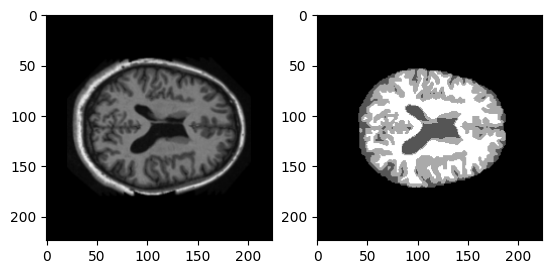

In [ ]:
#visualise image and mask of the second entry in the CrackDataset dataset.
ds = CrackDataset(train)
plt.subplot(121)
print(ds[1][0].shape)
plt.imshow(ds[1][0].cpu().detach().numpy().transpose(1,2,0))
plt.subplot(122)
plt.imshow(ds[1][1].cpu().detach().numpy().transpose(1,2,0), cmap='gray')

In [ ]:
#instances of the brainDataset-  The datasets will read images and masks, apply specified transforms (train_transforms), and convert grayscale mask values into
#class labels according to the defined class_mapping.
train_dataset = brainDataset(train, transforms=train_transforms)
valid_dataset = brainDataset(valid, transforms=train_transforms)

# Define batch size
batch_size = 4

# Create data loaders- facilitate easier batching, shuffling, and parallel processing of datasets.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=valid_dataset.collate_fn)


In [ ]:
import torch
# Dice coefficient of predicted mask and the true mask
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)

    # Flatten the tensors
    m1 = pred.view(num, -1).float()
    m2 = target.view(num, -1).float()

    # Check if the sizes are compatible
    if m1.size(1) != m2.size(1):
        raise RuntimeError("Sizes of tensors must match at non-singleton dimension 1")

    intersection = (m1 * m2).sum(dim=1)
    return (2. * intersection + smooth) / (m1.sum(dim=1) + m2.sum(dim=1) + smooth)

In [ ]:
#--------------------------UNet-------------------------
# training and validation loops for a U-Net model
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
# Define your UNet model with the appropriate number of classes
num_classes = 4

# Define a loss function (e.g., CrossEntropyLoss) and an optimizer (e.g., Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Initialize validation Dice score
val_dice = 0.0
train_dice = 0.0

# Set up device (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_pixels_train = 0
    total_pixels_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass-passing an input through the network layers
        outputs = model(inputs)
        labels = labels.squeeze(1).long()

        # Calculate the loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Calculate accuracy (IoU) for training
        _, predicted = torch.max(outputs, 1)
        correct_pixels_train += torch.sum(predicted == labels).item()
        total_pixels_train += labels.numel()

    # Compute training accuracy and IoU
    train_accuracy = correct_pixels_train / total_pixels_train

    # Validation-  set the model in evaluation mode and iterated over the valid_dataloader
    model.eval()
    correct_pixels_val = 0
    total_pixels_val = 0
    validation_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_labels in valid_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_labels = val_labels.squeeze(1).long()

            # Calculate accuracy (IoU) for validation
            _, val_predicted = torch.max(val_outputs, 1)
            correct_pixels_val += torch.sum(val_predicted == val_labels).item()
            total_pixels_val += val_labels.numel()

            # Calculate the validation loss
            val_loss = criterion(val_outputs, val_labels)
            validation_loss += val_loss.item()

    # Compute validation accuracy and IoU
    val_accuracy = correct_pixels_val / total_pixels_val

    # Calculate Dice score for training
    train_dice = 2 * correct_pixels_train / (total_pixels_train + correct_pixels_train)
    # Calculate Dice score for validation
    val_dice = 2 * correct_pixels_val / (total_pixels_val + correct_pixels_val)

    # Print metrics for the current epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Training Loss: {running_loss:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}")  # Print validation loss
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Training Dice Score: {train_dice:.4f}")
    print(f"Validation Dice Score: {val_dice:.4f}")
    print("=" * 40)

print("Training finished.")

Epoch [1/10]
Training Loss: 45.4388
Validation Loss: 6.6776
Training Accuracy: 0.9583
Validation Accuracy: 0.9720
Training Dice Score: 0.9787
Validation Dice Score: 0.9858
Epoch [2/10]
Training Loss: 23.1679
Validation Loss: 5.7518
Training Accuracy: 0.9756
Validation Accuracy: 0.9755
Training Dice Score: 0.9876
Validation Dice Score: 0.9876
Epoch [3/10]
Training Loss: 19.7273
Validation Loss: 4.5686
Training Accuracy: 0.9790
Validation Accuracy: 0.9806
Training Dice Score: 0.9894
Validation Dice Score: 0.9902
Epoch [4/10]
Training Loss: 18.3840
Validation Loss: 4.2980
Training Accuracy: 0.9804
Validation Accuracy: 0.9816
Training Dice Score: 0.9901
Validation Dice Score: 0.9907
Epoch [5/10]
Training Loss: 16.8768
Validation Loss: 4.2756
Training Accuracy: 0.9820
Validation Accuracy: 0.9815
Training Dice Score: 0.9909
Validation Dice Score: 0.9907
Epoch [6/10]
Training Loss: 15.1363
Validation Loss: 3.3697
Training Accuracy: 0.9839
Validation Accuracy: 0.9857
Training Dice Score: 0.991

In [ ]:
# Define a file path where you want to save your model
model_path = '/content/drive/MyDrive/keras_png_slices_data/unet_model.pth'

# Save the model and its state_dict along with other information you may need
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': running_loss,
    'validation_loss': validation_loss,
}, model_path)

print(f"Model saved to {model_path}")


Model saved to /content/drive/MyDrive/keras_png_slices_data/unet_model.pth


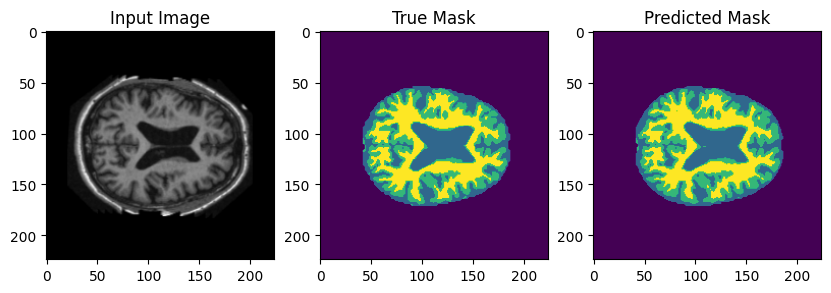

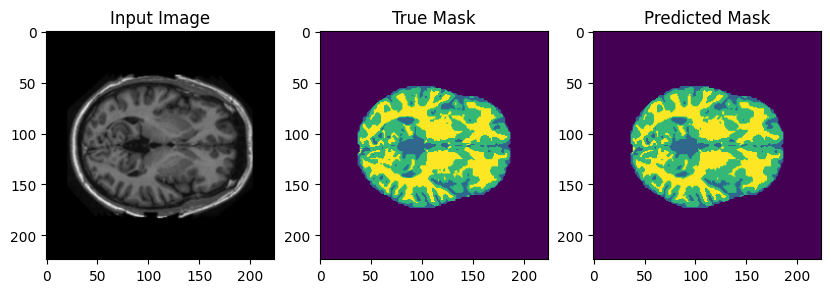

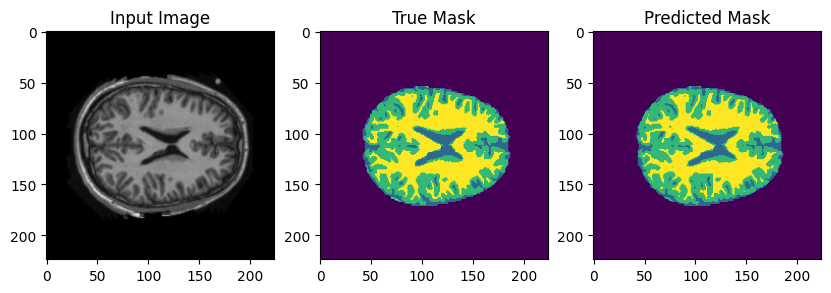

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#visualises input images, their corresponding true masks, and the masks predicted by the model from a validation dataset.

num_images_to_display = 3

for i, (val_inputs, val_labels) in enumerate(valid_dataloader):
    if i >= num_images_to_display:
        break

    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

    # Forward pass to get predicted masks
    val_outputs = model(val_inputs)
    val_labels = val_labels.squeeze(1).long()
    _, val_predicted = torch.max(val_outputs, 1)

    # Convert tensors to numpy arrays for visualization
    input_image = val_inputs[0].cpu().numpy().transpose(1, 2, 0)  # Assuming channel-last format
    true_mask = val_labels[0].cpu().numpy()
    predicted_mask = val_predicted[0].cpu().numpy()

    # Create subplots for input image, true mask, and predicted mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(input_image)

    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(true_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)

    plt.show()


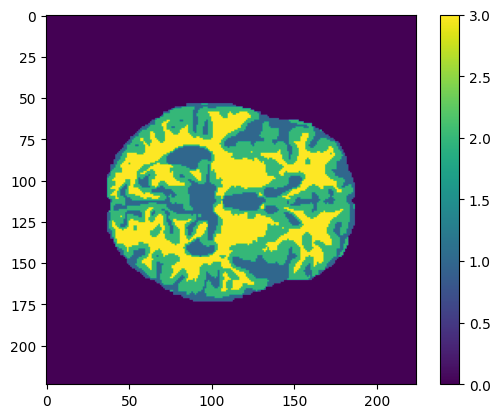

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp  # Make sure to import the segmentation model library

# Load the trained model
model_path = '/content/drive/MyDrive/keras_png_slices_data/unet_model.pth'
num_classes = 4  # Number of classes in your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the UNet model architecture (same as during training)
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None,  # Weights are not needed for inference
    in_channels=3, #RGB
    classes=num_classes
)
model.to(device)

# Load the model's state_dict-  maps each layer in model to its corresponding parameters (tensors).
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load and preprocess the input image
image_path = '/content/drive/MyDrive/keras_png_slices_data/keras_png_slices_train/case_001_slice_0.nii.png'  # Replace with the path to your test image
image = Image.open(image_path)

# Convert grayscale image to RGB
if image.mode == 'L':
    image = image.convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_image = transform(image)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_image.unsqueeze(0).to(device))

# Post-process the output to obtain segmentation results
output_softmax = torch.softmax(output, dim=1)  # Apply softmax to get class probabilities
_, predicted_class = torch.max(output_softmax, dim=1)  # Get the predicted class

# Convert the predicted_class tensor to a numpy array
predicted_class = predicted_class.squeeze(0).cpu().numpy()

# visualise the segmentation results
plt.imshow(predicted_class,cmap='viridis', vmin=0, vmax=num_classes - 1)
plt.colorbar()
plt.show()
